In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Load ratings data
ratings= pd.read_csv(r"D:\notebooks\recommendationSysetms\ml-1m\ml-1m\ratings.dat", sep='::',
 names= ['user_id', 'movie_id', 'rating', 'timestamp'])
print(ratings.head())
# load movies data
movies= pd.read_csv(r"D:\notebooks\recommendationSysetms\ml-1m\ml-1m\movies.dat", sep='::',names=['movie_id', 'title', 'genres'],encoding='latin-1')
print(movies.head())
#load users data
users= pd.read_csv(r"D:\notebooks\recommendationSysetms\ml-1m\ml-1m\users.dat", sep='::', 
                   names=['user_id', 'gender', 'age', 'occupation', 'zip'],)
print(users.head())


   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
   user_id gender  age  occupation    zip
0        1      F    1          10  48067
1        2      M   56          16  70072
2        3      M   25          15  55117
3        4      M   45           7  02460
4        5      M   25          20  55455


# Exploratory Data Analysis

In [21]:
n_ratings= len(ratings)
n_movies= movies.nunique()
n_users= len(users)
print(f'Number of ratings: {n_ratings}')
print(f'Number of unique movies: {n_movies}')
print(f'Number of users: {n_users}')
print(f'Rating range: {ratings['rating'].min()}- {ratings['rating'].max()}')

Number of ratings: 1000209
Number of unique movies: movie_id    3883
title       3883
genres       301
dtype: int64
Number of users: 6040
Rating range: 1- 5


### Distribution of movie ratings

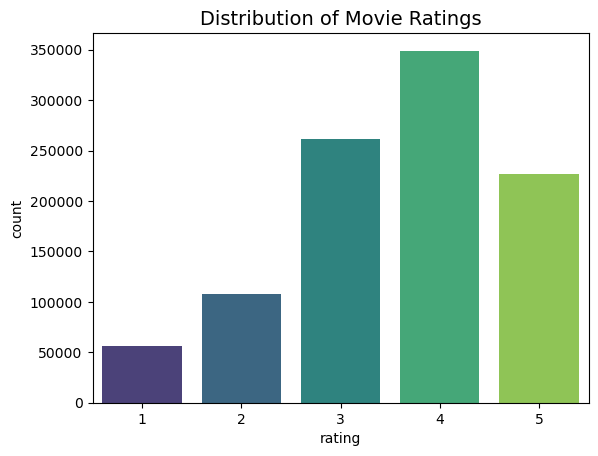

In [22]:
sns.countplot(x= 'rating', data= ratings, palette= 'viridis')
plt.title("Distribution of Movie Ratings", fontsize= 14)
plt.show()

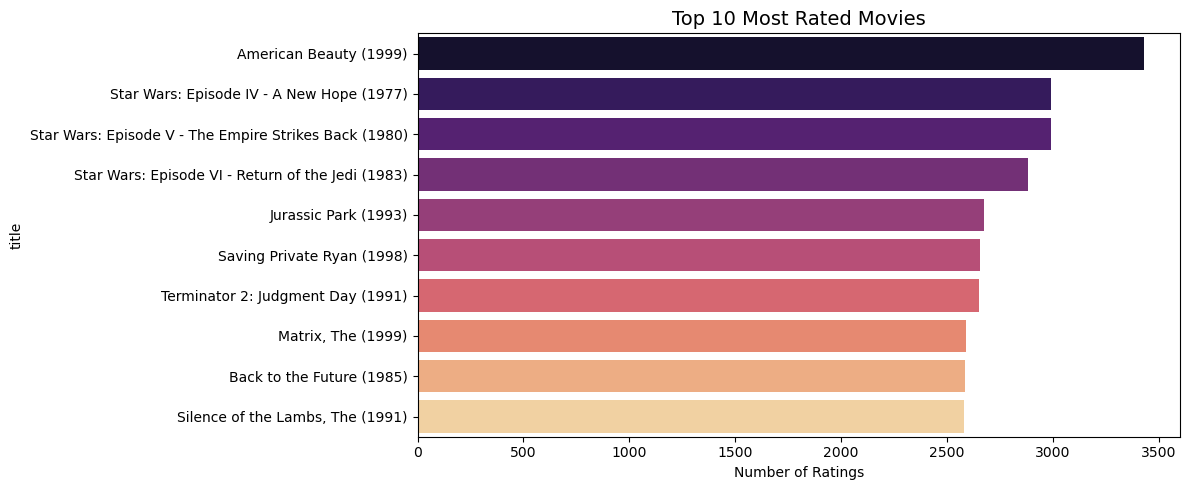

In [23]:
# Top 10 most rated movies
movie_ratings= ratings.merge(movies, on ='movie_id')
top10= movie_ratings['title'].value_counts().head(10)
plt.figure(figsize= (12,5))
sns.barplot(x= top10.values, y= top10.index, palette='magma')
plt.title('Top 10 Most Rated Movies', fontsize=14)
plt.xlabel('Number of Ratings')
plt.tight_layout()
plt.show()


In [24]:
# Highest & lowest average rated movies min 50 ratings for fairness
mean_ratings= ratings.groupby('movie_id')[['rating']].mean()
lowest_rated= mean_ratings['rating'].min()
print(f' The lowest movie :{movies[movies['movie_id']== lowest_rated]}')
highest_rated= mean_ratings['rating'].max()
print(f'The highets movie :{movies[movies['movie_id'] == highest_rated]}')


 The lowest movie :   movie_id             title                       genres
0         1  Toy Story (1995)  Animation|Children's|Comedy
The highets movie :   movie_id                               title  genres
4         5  Father of the Bride Part II (1995)  Comedy


# Preprocessing & Feature Engineering

In [25]:
# Convert userId and movieId into sequential integer indices for embedding-based models.
user_ids = sorted(ratings['user_id'].unique())
movie_ids = sorted(ratings['movie_id'].unique())

user_encoded= {x: i for i, x in enumerate(user_ids)}
movie_encoded= {x: i for i, x in enumerate(movie_ids)}
user_decoded= {i: x for i, x in enumerate(user_ids)}
movie_decoded = {i: x for i, x in enumerate(movie_ids)}

ratings['user_enc']= ratings['user_id'].map(user_encoded)
movies['movie_enc']= movies['movie_id'].map(movie_encoded)
N_USERS  = len(user_ids)
N_MOVIES = len(movie_ids)
print(f'Number of Users={N_USERS} | Number of Movies={N_MOVIES}')

Number of Users=6040 | Number of Movies=3706


In [26]:
movies['movie_enc'].isna().sum()

np.int64(177)

In [27]:
movies.dropna(inplace= True)

In [28]:
movies['movie_enc'].isna().sum()

np.int64(0)

In [29]:
# Genre One-Hot Encoding
genres_ohe = movies['genres'].str.get_dummies(sep='|')
GENRE_COLS = genres_ohe.columns.tolist()
N_GENRES   = len(GENRE_COLS)
print(f'Genres ({N_GENRES}): {GENRE_COLS}')

Genres (18): ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [30]:
# Extract & Scale Year
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
movies['year'] = movies['year'].fillna(movies['year'].median())

scaler = MinMaxScaler()
movies['year_scaled'] = scaler.fit_transform(movies[['year']])

In [31]:
# Encode User Features
gender_map= {'F': 0, "M": 1}
users['gender_enc']=users['gender'].map(gender_map) 

age_values= sorted(users['age'].unique())
age_map= {v: i for i, v in enumerate(age_values)}
users['age_enc'] = users['age'].map(age_map)

N_GENDERS= users['gender_enc'].nunique()
N_AGES= users['age_enc'].nunique()
N_OCCUPATIONS= users['occupation'].nunique()

print(f'N_GENDERS={N_GENDERS} | N_AGES={N_AGES} | N_OCCUPATIONS={N_OCCUPATIONS}')

N_GENDERS=2 | N_AGES=7 | N_OCCUPATIONS=21


In [32]:
# Merge
movie_full= pd.concat([movies, genres_ohe], axis= 1)
full_df= (ratings.merge(movie_full, on= 'movie_id')
.merge(users[['user_id', 'gender_enc', 'age_enc', 'occupation']], on='user_id')
.sort_values('timestamp')
.reset_index(drop= True))
print(full_df.shape)

(1000209, 31)


In [33]:
full_df.head()

,user_id,movie_id,rating,timestamp,user_enc,title,genres,movie_enc,year,year_scaled,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,gender_enc,age_enc,occupation
0,6040,858,4,956703932,6039,"Godfather, The (1972)",Action|Crime|Drama,802.0,1972.0,0.654321,...,0,0,0,0,0,0,0,1,2,6
1,6040,593,5,956703954,6039,"Silence of the Lambs, The (1991)",Drama|Thriller,579.0,1991.0,0.888889,...,0,0,0,0,1,0,0,1,2,6
2,6040,2384,4,956703954,6039,Babe: Pig in the City (1998),Children's|Comedy,2191.0,1998.0,0.975309,...,0,0,0,0,0,0,0,1,2,6
3,6040,1961,4,956703977,6039,Rain Man (1988),Drama,1781.0,1988.0,0.851852,...,0,0,0,0,0,0,0,1,2,6
4,6040,2019,5,956703977,6039,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama,1839.0,1954.0,0.432099,...,0,0,0,0,0,0,0,1,2,6


# Train / Test Split (Chronological)

In [34]:
full_df.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'user_enc', 'title',
       'genres', 'movie_enc', 'year', 'year_scaled', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'gender_enc', 'age_enc',
       'occupation'],
      dtype='object')

In [35]:
train_size = int(0.8 * len(full_df))
train_df   = full_df.iloc[:train_size]
test_df    = full_df.iloc[train_size:]

print(f'Train size: {len(train_df):,}')
print(f'Test size:  {len(test_df):,}')

Train size: 800,167
Test size:  200,042


# Retrieval

In [36]:
train_df = train_df.copy()
test_df  = test_df.copy()
train_df['liked'] = (train_df['rating'] >= 4).astype('float32')
test_df['liked']  = (test_df['rating']  >= 4).astype('float32')

In [37]:
EMBED_DIM = 32
TOWER_DIM = 64

#User Tower
inp_user   = keras.Input(shape=(1,), name='user_enc')
inp_gender = keras.Input(shape=(1,), name='gender_enc')
inp_age    = keras.Input(shape=(1,), name='age_enc')
inp_occ    = keras.Input(shape=(1,), name='occupation')

user_concat = layers.Concatenate()([  
    layers.Flatten()(layers.Embedding(N_USERS,       EMBED_DIM, name='user_emb')(inp_user)),
    layers.Flatten()(layers.Embedding(N_GENDERS,     8,         name='gender_emb')(inp_gender)),
    layers.Flatten()(layers.Embedding(N_AGES,        8,         name='age_emb')(inp_age)),
    layers.Flatten()(layers.Embedding(N_OCCUPATIONS, 8,         name='occ_emb')(inp_occ)),
])
user_x = layers.Dense(TOWER_DIM, activation='relu')(user_concat)
user_x = layers.Dropout(0.2)(user_x)
user_x = layers.Dense(TOWER_DIM, activation='relu')(user_x)

# L2 normalize → dot product = cosine similarity
user_vector = layers.Lambda(
    lambda x: tf.nn.l2_normalize(x, axis=1),
    name='user_vector'
)(user_x)

# Movie Tower
inp_movie = keras.Input(shape=(1,),        name='movie_enc')
inp_genre = keras.Input(shape=(N_GENRES,), name='genre')
inp_year  = keras.Input(shape=(1,),        name='year_scaled')

movie_concat = layers.Concatenate()([
    layers.Flatten()(layers.Embedding(N_MOVIES, EMBED_DIM, name='movie_emb')(inp_movie)),
    inp_genre,
    inp_year,
])

movie_x = layers.Dense(TOWER_DIM, activation='relu')(movie_concat)
movie_x = layers.Dropout(0.2)(movie_x)
movie_x = layers.Dense(TOWER_DIM, activation='relu')(movie_x)

movie_vector = layers.Lambda(
    lambda x: tf.nn.l2_normalize(x, axis=1),
    name='movie_vector'
)(movie_x)

# ── Dot Product → Sigmoid (Retrieval score 0-1) ───────────────────────
dot    = layers.Dot(axes=1, name='dot_product')([user_vector, movie_vector])
output = layers.Dense(1, activation='sigmoid', name='retrieval_output')(dot)

retrieval_model = keras.Model(
    inputs  = [inp_user, inp_gender, inp_age, inp_occ,
               inp_movie, inp_genre, inp_year],
    outputs = output,
    name    = 'RetrievalModel'
)

retrieval_model.summary()

Model: "RetrievalModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_enc            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_enc          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_enc             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occupation          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_enc           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb            │ (None, 1, 32)     │    193,280 │ user_enc[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_emb          │ (None, 1, 8)      │         16 │ gender_enc[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_emb (Embedding) │ (None, 1, 8)      │         56 │ age_enc[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occ_emb (Embedding) │ (None, 1, 8)      │        168 │ occupation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_emb           │ (None, 1, 32)     │    118,592 │ movie_enc[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ user_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ gender_emb[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8)         │          0 │ age_emb[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 8)         │          0 │ occ_emb[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 32)        │          0 │ movie_emb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre (InputLayer)  │ (None, 18)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_scaled         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 51)        │          0 │ flatten_4[0][0],

 Total params: 327,410 (1.25 MB)

 Trainable params: 327,410 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
def build_retrieval_inputs(df):
    return {
        'user_enc':    df['user_enc'].astype('int32').values,
        'gender_enc':  df['gender_enc'].astype('int32').values,
        'age_enc':     df['age_enc'].astype('int32').values,
        'occupation':  df['occupation'].astype('int32').values,
        'movie_enc':   df['movie_enc'].astype('int32').values,
        'genre':       df[GENRE_COLS].astype('float32').values,
        'year_scaled': df[['year_scaled']].astype('float32').values,
    }

X_ret_train = build_retrieval_inputs(train_df)
X_ret_test  = build_retrieval_inputs(test_df)
y_ret_train = train_df['liked'].values
y_ret_test  = test_df['liked'].values

retrieval_model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss      = 'binary_crossentropy',
    metrics   = ['AUC']
)

history_ret = retrieval_model.fit(
    X_ret_train, y_ret_train,
    validation_data = (X_ret_test, y_ret_test),
    epochs     = 17,
    batch_size = 2048,
    callbacks  = [
        keras.callbacks.EarlyStopping(
            monitor='val_AUC', patience=3,
            restore_best_weights=True, mode='max', verbose=1
        )
    ],
    verbose = 1
)

Epoch 1/17
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - AUC: 0.6755 - loss: 0.6637 - val_AUC: 0.7031 - val_loss: 0.6450
Epoch 2/17
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - AUC: 0.7500 - loss: 0.6174 - val_AUC: 0.7239 - val_loss: 0.6234
Epoch 3/17
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - AUC: 0.7692 - loss: 0.5908 - val_AUC: 0.7325 - val_loss: 0.6104
Epoch 4/17
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - AUC: 0.7779 - loss: 0.5739 - val_AUC: 0.7348 - val_loss: 0.6032
Epoch 5/17
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - AUC: 0.7835 - loss: 0.5625 - val_AUC: 0.7381 - val_loss: 0.5977
Epoch 6/17
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - AUC: 0.7872 - loss: 0.5543 - val_AUC: 0.7387 - val_loss: 0.5956
Epoch 7/17
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - AUC: 0.7913 - loss: 0.5482 - val_AUC: 0.7385 - val_loss: 0.5934
Epoch 8/17
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - AUC: 0.7945 - loss: 0.5431 - val_AUC: 0.7423 - val_loss: 0.5907
Epoch 9/17
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/s

In [39]:
user_tower_model = keras.Model(
    inputs  = [inp_user, inp_gender, inp_age, inp_occ],
    outputs = user_vector,
    name    = 'UserTower'
)

movie_tower_model = keras.Model(
    inputs  = [inp_movie, inp_genre, inp_year],
    outputs = movie_vector,
    name    = 'MovieTower'
)

print('User Tower & Movie Tower extracted successfully')

User Tower & Movie Tower extracted successfully


In [40]:
# Pre-compute ALL Movie Vectors (offline) 
all_movie_inputs = {
    'movie_enc':   movie_full['movie_enc'].astype('int32').values,
    'genre':       movie_full[GENRE_COLS].astype('float32').values,
    'year_scaled': movie_full[['year_scaled']].astype('float32').values,
}

all_movie_vectors = movie_tower_model.predict(all_movie_inputs, verbose=0)
print(f'Movie vectors shape: {all_movie_vectors.shape}')

Movie vectors shape: (3706, 64)


In [41]:
def retrieve_candidates(user_id, top_k=200):
    '''
      The system quickly finds the top_k closest movies for the user by computing the dot product similarity between:
      user & movie vectors
    '''
    u_info = users[users['user_id'] == user_id].iloc[0]

    user_input = {
        'user_enc':   np.array([[user_encoded[user_id]]]),
        'gender_enc': np.array([[u_info['gender_enc']]]),
        'age_enc':    np.array([[u_info['age_enc']]]),
        'occupation': np.array([[u_info['occupation']]]),
    }
    u_vec = user_tower_model.predict(user_input, verbose=0)  

    scores = all_movie_vectors @ u_vec.T   
    scores = scores.flatten()

    # Filter movies already rated
    rated = set(ratings[ratings['user_id'] == user_id]['movie_id'])
    candidates = movie_full.copy()
    candidates['retrieval_score'] = scores
    candidates = candidates[~candidates['movie_id'].isin(rated)]

    # Top K candidates
    top_candidates = candidates.nlargest(top_k, 'retrieval_score')
    return top_candidates, u_vec

# Test
candidates, u_vec = retrieve_candidates(user_id=1, top_k=200)
print(f'Retrieved {len(candidates)} candidates for User 1')
print(candidates[['title', 'retrieval_score']].head(10))

Retrieved 200 candidates for User 1
                                                 title  retrieval_score
1580                                 Wishmaster (1997)         0.955749
2651                           Inspector Gadget (1999)         0.954268
1759                   Barney's Great Adventure (1998)         0.954108
2313  Police Academy 5: Assignment: Miami Beach (1988)         0.952649
2447                   Children of the Corn III (1994)         0.952624
2747                              Iron Eagle II (1988)         0.952572
3524                          Battlefield Earth (2000)         0.951495
800                                      Kazaam (1996)         0.950826
2314         Police Academy 6: City Under Siege (1989)         0.950443
2896                            Omega Code, The (1999)         0.949144


# RANKING 

In [42]:
# we take the user & movie vectors from the reterival model and use them as features for the ranking model
print('Computing user vectors for training set...')
train_user_inputs = {
    'user_enc':   train_df['user_enc'].astype('int32').values.reshape(-1,1),
    'gender_enc': train_df['gender_enc'].astype('int32').values.reshape(-1,1),
    'age_enc':    train_df['age_enc'].astype('int32').values.reshape(-1,1),
    'occupation': train_df['occupation'].astype('int32').values.reshape(-1,1),
}
train_user_vecs = user_tower_model.predict(train_user_inputs, batch_size=4096, verbose=1)

print('Computing movie vectors for training set...')
m_enc  = train_df['movie_enc'].to_numpy(dtype='int32').reshape(-1,1)
m_gen  = train_df[GENRE_COLS].to_numpy(dtype='float32')
m_year = train_df[['year_scaled']].to_numpy(dtype='float32')
train_movie_vecs = movie_tower_model.predict([m_enc, m_gen, m_year], batch_size=4096, verbose=1)

# Test
test_user_inputs = {
    'user_enc':   test_df['user_enc'].astype('int32').values.reshape(-1,1),
    'gender_enc': test_df['gender_enc'].astype('int32').values.reshape(-1,1),
    'age_enc':    test_df['age_enc'].astype('int32').values.reshape(-1,1),
    'occupation': test_df['occupation'].astype('int32').values.reshape(-1,1),
}
test_user_vecs = user_tower_model.predict(test_user_inputs, batch_size=4096, verbose=0)

tm_enc  = test_df['movie_enc'].to_numpy(dtype='int32').reshape(-1,1)
tm_gen  = test_df[GENRE_COLS].to_numpy(dtype='float32')
tm_year = test_df[['year_scaled']].to_numpy(dtype='float32')
test_movie_vecs = movie_tower_model.predict([tm_enc, tm_gen, tm_year], batch_size=4096, verbose=0)

print(f'\nUser vectors shape:  {train_user_vecs.shape}')
print(f'Movie vectors shape: {train_movie_vecs.shape}')

Computing user vectors for training set...
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Computing movie vectors for training set...
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

User vectors shape:  (800167, 64)
Movie vectors shape: (800167, 64)


In [43]:
# Input = [user_vector(64) + movie_vector(64)] → 128 features

rank_input = keras.Input(shape=(TOWER_DIM * 2,), name='ranking_input')

x = layers.Dense(256, activation='relu')(rank_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)

rank_output = layers.Dense(1, activation='linear', name='rating_pred')(x)

ranking_model = keras.Model(
    inputs  = rank_input,
    outputs = rank_output,
    name    = 'RankingModel'
)
ranking_model.summary()

Model: "RankingModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ranking_input (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rating_pred (Dense)             │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,777 (296.00 KB)

 Trainable params: 75,009 (293.00 KB)

 Non-trainable params: 768 (3.00 KB)

In [44]:
# ── Concatenate user + movie vectors as ranking features ──────────────
X_rank_train = np.concatenate([train_user_vecs, train_movie_vecs], axis=1)
X_rank_test  = np.concatenate([test_user_vecs,  test_movie_vecs],  axis=1)
y_rank_train = train_df['rating'].astype('float32').values
y_rank_test  = test_df['rating'].astype('float32').values

ranking_model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss      = 'mse',
    metrics   = ['mae']
)

history_rank = ranking_model.fit(
    X_rank_train, y_rank_train,
    validation_data = (X_rank_test, y_rank_test),
    epochs     = 20,
    batch_size = 2048,
    callbacks  = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=3,
            restore_best_weights=True, verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5,
            patience=2, verbose=1
        )
    ],
    verbose = 1
)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 1.2643 - mae: 0.8820 - val_loss: 1.0260 - val_mae: 0.8189 - learning_rate: 0.0010
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.9752 - mae: 0.7833 - val_loss: 0.9340 - val_mae: 0.7636 - learning_rate: 0.0010
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.9342 - mae: 0.7659 - val_loss: 0.9271 - val_mae: 0.7601 - learning_rate: 0.0010
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 0.9124 - mae: 0.7563 - val_loss: 0.9331 - val_mae: 0.7724 - learning_rate: 0.0010
Epoch 5/20
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.8985 - mae: 0.7502
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 0.8955 - mae: 0.7490 - val_loss: 0.9295 - val_mae: 0.7626 - learning_rate: 0.0010
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.8851 - mae: 0.7442 - val_loss: 0.9272 - val_mae: 0.7609 - learning_rate:

## Evaluate Ranking Model

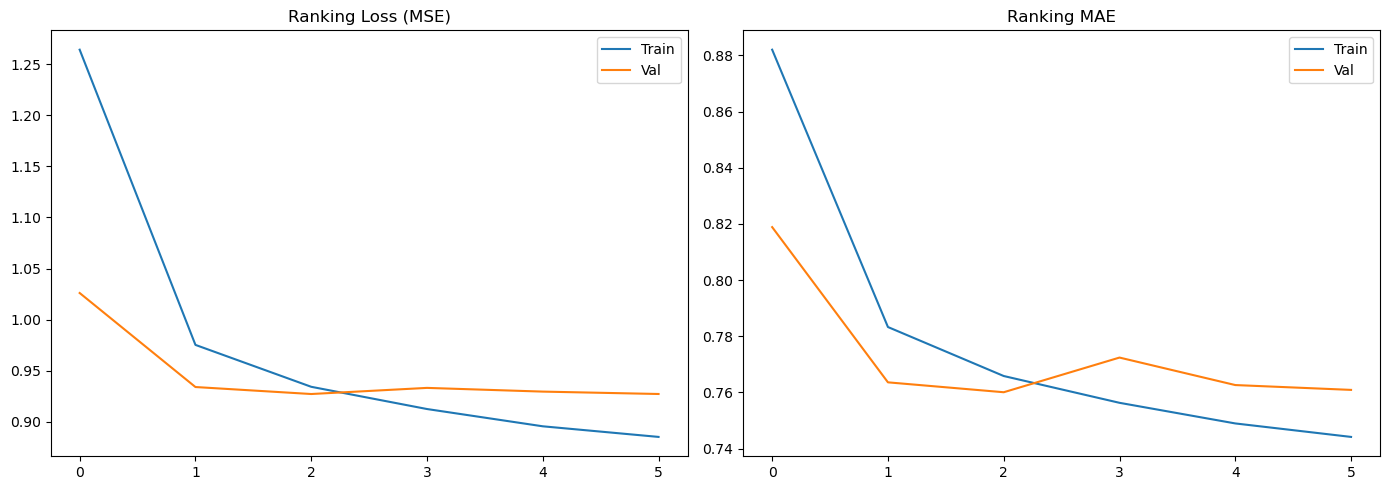

Ranking Model Results:
RMSE : 0.9629
MAE  : 0.7601


In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_rank.history['loss'],     label='Train')
axes[0].plot(history_rank.history['val_loss'], label='Val')
axes[0].set_title('Ranking Loss (MSE)')
axes[0].legend()

axes[1].plot(history_rank.history['mae'],     label='Train')
axes[1].plot(history_rank.history['val_mae'], label='Val')
axes[1].set_title('Ranking MAE')
axes[1].legend()

plt.tight_layout()
plt.show()

loss, mae = ranking_model.evaluate(X_rank_test, y_rank_test, verbose=0)
print(f'Ranking Model Results:')
print(f'RMSE : {np.sqrt(loss):.4f}')
print(f'MAE  : {mae:.4f}')

In [46]:
def recommend_movies(user_id, top_k_retrieve=200, top_n_final=10):
    if user_id not in user_encoded:
        print(f'User {user_id} not found.')
        return

    u_info = users[users['user_id'] == user_id].iloc[0]
    print(f'User {user_id} | Gender: {u_info["gender"]} | Age: {u_info["age"]}')

    # STAGE 1: RETRIEVAL
    candidates, u_vec = retrieve_candidates(user_id, top_k=top_k_retrieve)
    print(f'\n Stage 1 — Retrieved {len(candidates)} candidates')

    # STAGE 2: RANKING 
    # We take the movie vectors directly from all_movie_vectors(variable) using indexing, instead of running predict again
    cand_indices    = candidates['movie_enc'].astype('int32').values
    cand_movie_vecs = all_movie_vectors[cand_indices]  # precomputed

    # Repeat user vector for each candidate
    u_vecs_repeated  = np.repeat(u_vec, len(candidates), axis=0)

    # Ranking features
    ranking_features = np.concatenate([u_vecs_repeated, cand_movie_vecs], axis=1)
    ranking_scores   = ranking_model.predict(ranking_features, verbose=0).flatten()

    candidates = candidates.copy()
    candidates['ranking_score'] = ranking_scores

    top_movies = candidates.nlargest(top_n_final, 'ranking_score')

    print(f'\n Stage 2 — Top {top_n_final} Final Recommendations:')
    print('-' * 70)
    for i, row in enumerate(top_movies.itertuples(), 1):
        print(f'{i:2}. {row.title:<45} {row.ranking_score:.2f}  (retrieval: {row.retrieval_score:.3f})')

recommend_movies(user_id=3)

User 3 | Gender: M | Age: 25

 Stage 1 — Retrieved 200 candidates

 Stage 2 — Top 10 Final Recommendations:
----------------------------------------------------------------------
 1. Jerky Boys, The (1994)                        1.97  (retrieval: 0.980)
 2. Guardian, The (1990)                          1.96  (retrieval: 0.980)
 3. Haunting, The (1999)                          1.96  (retrieval: 0.980)
 4. Thomas and the Magic Railroad (2000)          1.96  (retrieval: 0.980)
 5. Quest for Camelot (1998)                      1.95  (retrieval: 0.980)
 6. Play it to the Bone (1999)                    1.95  (retrieval: 0.980)
 7. Woo (1998)                                    1.95  (retrieval: 0.980)
 8. House on Haunted Hill, The (1999)             1.95  (retrieval: 0.980)
 9. Digimon: The Movie (2000)                     1.95  (retrieval: 0.980)
10. Retro Puppetmaster (1999)                     1.95  (retrieval: 0.981)


In [47]:
OUT_DIR = Path(r"D:\notebooks\recommendationSysetms")
OUT_DIR.mkdir(exist_ok=True)

# Save models
retrieval_model.save(OUT_DIR / "retrieval_model.keras")
user_tower_model.save(OUT_DIR / "user_tower.keras")
movie_tower_model.save(OUT_DIR / "movie_tower.keras")
ranking_model.save(OUT_DIR / "ranking_model.keras")

# Save precomputed movie vectors
np.save(OUT_DIR / "all_movie_vectors.npy", all_movie_vectors)

# Save encoders / mappings
encoders = {
    "user_encoded":  user_encoded,
    "user_decoded":  user_decoded,
    "movie_encoded": movie_encoded,
    "movie_decoded": movie_decoded,
    "age_map":       age_map,
    "gender_map":    gender_map,
}
with open(OUT_DIR / "encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

# Save scaler
joblib.dump(scaler, OUT_DIR / "year_scaler.pkl")

# Save genre columns order
with open(OUT_DIR / "genre_cols.pkl", "wb") as f:
    pickle.dump(GENRE_COLS, f)

# Save required dataframes for inference
movie_full.to_parquet(OUT_DIR / "movie_full.parquet", index=False)
users.to_parquet(OUT_DIR / "users.parquet", index=False)

print("Saved artifacts to:", OUT_DIR.resolve())
print("Files:", [p.name for p in OUT_DIR.iterdir()])

Saved artifacts to: D:\notebooks\recommendationSysetms
Files: ['all_movie_vectors.npy', 'encoders.pkl', 'genre_cols.pkl', 'main.py', 'ml-1m', 'models', 'movie_full.parquet', 'movie_tower.keras', 'ranking_model.keras', 'recommendation_system.ipynb', 'retrieval_model.keras', 'users.parquet', 'user_tower.keras', 'venv', 'year_scaler.pkl', '__pycache__']


In [49]:
OUT_DIR = Path(r"D:\notebooks\recommendationSysetms\models")
OUT_DIR.mkdir(exist_ok=True)

#  User Tower without using lambda
inp_u   = keras.Input(shape=(1,), name='user_enc')
inp_g   = keras.Input(shape=(1,), name='gender_enc')
inp_a   = keras.Input(shape=(1,), name='age_enc')
inp_o   = keras.Input(shape=(1,), name='occupation')

u_emb = keras.layers.Embedding(N_USERS,       EMBED_DIM, name='user_emb')
g_emb = keras.layers.Embedding(N_GENDERS,     8,         name='gender_emb')
a_emb = keras.layers.Embedding(N_AGES,        8,         name='age_emb')
o_emb = keras.layers.Embedding(N_OCCUPATIONS, 8,         name='occ_emb')

u_cat = layers.Concatenate()([
    layers.Flatten()(u_emb(inp_u)),
    layers.Flatten()(g_emb(inp_g)),
    layers.Flatten()(a_emb(inp_a)),
    layers.Flatten()(o_emb(inp_o)),
])

d1u = keras.layers.Dense(TOWER_DIM, activation='relu')
dr1 = keras.layers.Dropout(0.2)
d2u = keras.layers.Dense(TOWER_DIM, activation='relu')

u_vec = keras.layers.UnitNormalization(axis=1)(d2u(dr1(d1u(u_cat))))

user_tower_new = keras.Model(
    inputs=[inp_u, inp_g, inp_a, inp_o],
    outputs=u_vec,
    name='UserTower'
)

# copy wights
u_emb.set_weights(user_tower_model.get_layer('user_emb').get_weights())
g_emb.set_weights(user_tower_model.get_layer('gender_emb').get_weights())
a_emb.set_weights(user_tower_model.get_layer('age_emb').get_weights())
o_emb.set_weights(user_tower_model.get_layer('occ_emb').get_weights())
d1u.set_weights(user_tower_model.get_layer('dense').get_weights())
d2u.set_weights(user_tower_model.get_layer('dense_1').get_weights())

# 
test_u = {'user_enc': np.array([[0]]), 'gender_enc': np.array([[0]]),
          'age_enc':  np.array([[0]]), 'occupation': np.array([[0]])}
match_u = np.allclose(user_tower_model.predict(test_u, verbose=0),
                      user_tower_new.predict(test_u, verbose=0), atol=1e-5)
print(f"✅ User Tower match: {match_u}")


# Movie Tower without Lambda 
inp_mv = keras.Input(shape=(1,),        name='movie_enc')
inp_gn = keras.Input(shape=(N_GENRES,), name='genre')
inp_yr = keras.Input(shape=(1,),        name='year_scaled')

m_emb = keras.layers.Embedding(N_MOVIES, EMBED_DIM, name='movie_emb')

m_cat = layers.Concatenate()([
    layers.Flatten()(m_emb(inp_mv)),
    inp_gn,
    inp_yr,
])

d1m = keras.layers.Dense(TOWER_DIM, activation='relu')
dr2 = keras.layers.Dropout(0.2)
d2m = keras.layers.Dense(TOWER_DIM, activation='relu')

m_vec = keras.layers.UnitNormalization(axis=1)(d2m(dr2(d1m(m_cat))))

movie_tower_new = keras.Model(
    inputs=[inp_mv, inp_gn, inp_yr],
    outputs=m_vec,
    name='MovieTower'
)

# copy weights
m_emb.set_weights(movie_tower_model.get_layer('movie_emb').get_weights())
d1m.set_weights(movie_tower_model.get_layer('dense_2').get_weights())
d2m.set_weights(movie_tower_model.get_layer('dense_3').get_weights())

test_m = {'movie_enc': np.array([[0]]),
          'genre':     np.zeros((1, N_GENRES), dtype='float32'),
          'year_scaled': np.array([[0.5]])}
match_m = np.allclose(movie_tower_model.predict(test_m, verbose=0),
                      movie_tower_new.predict(test_m, verbose=0), atol=1e-5)
print(f"✅ Movie Tower match: {match_m}")


# save models
user_tower_new.save(OUT_DIR  / "user_tower.keras")
movie_tower_new.save(OUT_DIR / "movie_tower.keras")
ranking_model.save(OUT_DIR   / "ranking_model.keras")



✅ User Tower match: True
✅ Movie Tower match: True
